In [33]:
#Running on Python version 3.12.1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Import Data from US Bureau of Labor Statistics on Excel

In [34]:
Sheet4 = pd.read_excel('Kansas City Employment Data.xlsx', sheet_name="Unemployment tables", usecols='A:N')
Sheet5 = pd.read_excel('Consumer Price Index for All Urban Consumers.xlsx', sheet_name='BLS Data Series', header=11, usecols='A:M', index_col=0).fillna(0)

Cleaning Data

In [35]:
Unemployment = {}
for row,name in enumerate(Sheet4.iloc[:, 0]):
    if name == 'Row Labels':
        Unemployment[f'{Sheet4.iloc[row-1,0]}'] = Sheet4.iloc[row:row+13]


def clean(dictofdfs, indexcol):
    for table in dictofdfs:
        dictofdfs[table].reset_index(inplace=True, drop=True)
        dictofdfs[table].columns = dictofdfs[table].iloc[0]
        dictofdfs[table] = dictofdfs[table][1:].reset_index(drop=True)
        dictofdfs[table].set_index(dictofdfs[table][indexcol], inplace=True)
        dictofdfs[table].drop(indexcol, axis=1, inplace=True)
        dictofdfs[table].fillna(0, inplace=True)
        for col in dictofdfs[table]:
            dictofdfs[table][col] = dictofdfs[table][col].astype(str).str.replace(r'[^\d.]', '', regex=True).astype(float)
        dictofdfs[table].index.name = 'Year'

        
  
clean(Unemployment, 'Row Labels')

OEWS Occupational Employment and Wage Statistics
Kansas City GDP contribution by industry

In [36]:
OWEScolumns3 = ['AREA_TITLE', 'OCC_CODE', 'OCC_TITLE','O_GROUP','TOT_EMP','LOC_QUOTIENT','A_MEAN', 'H_MEDIAN', 'A_MEDIAN'] #2020-2023
OWEScolumns2 = ['area_title', 'occ_code', 'occ_title', 'o_group', 'tot_emp', 'loc_quotient', 'a_mean', 'h_median', 'a_median'] #2019
OWEScolumns1 = ['AREA_NAME', 'OCC_CODE', 'OCC_TITLE', 'OCC_GROUP', 'TOT_EMP', 'LOC QUOTIENT', 'A_MEAN', 'H_MEDIAN', 'A_MEDIAN'] #2014-2018

files = [f'MSA_M{x}_dl.xlsx' for x in range(2014,2024)]
OWES = {}
for file in files:
    print(file)
    try:
        try:
            OWES[f'{file}'] = pd.read_excel(file, sheet_name=0, index_col='AREA_NAME',header=0, usecols=OWEScolumns1)
        except:
            print('columns2')
            OWES[f'{file}'] = pd.read_excel(file, sheet_name=0, index_col='area_title',header=0, usecols=OWEScolumns2)
    except:
        print('columns3')
        OWES[f'{file}'] = pd.read_excel(file, sheet_name=0, index_col='AREA_TITLE',header=0, usecols=OWEScolumns3)

Clean OWES

In [37]:
for df in OWES:
    OWES[df].index.name = 'AREA_TITLE'
    OWES[df].columns = ['OCC_CODE','OCC_TITLE','O_GROUP','TOT_EMP','LOC_QUOTIENT','A_MEAN', 'H_MEDIAN', 'A_MEDIAN']
for df in OWES:
    OWES[df] = OWES[df].loc['Kansas City, MO-KS']
ALLYearsOWES = pd.DataFrame()
for df in OWES:
    OWES[df]['Year'] = f'{df[5:9]}'
    for row in OWES[df]:
        OWES[df]['Title_Year'] = OWES[df]['OCC_TITLE'] + df[5:9]
OWES['MSA_M2014_dl.xlsx']

OWES national data

In [38]:
OWEScolumns3 = ['OCC_CODE', 'OCC_TITLE','O_GROUP','TOT_EMP','A_MEAN', 'H_MEDIAN', 'A_MEDIAN'] #2020-2023
OWEScolumns2 = ['occ_code', 'occ_title', 'o_group', 'tot_emp', 'a_mean', 'h_median', 'a_median'] #2019
OWEScolumns1 = ['OCC_CODE', 'OCC_TITLE', 'OCC_GROUP', 'TOT_EMP', 'A_MEAN', 'H_MEDIAN', 'A_MEDIAN'] #2014-2018

files = [f'national_M{x}_dl.xlsx' for x in range(2014,2024)]
OWESN = {}
for file in files:
    print(file)
    try:
        try:
            OWESN[f'{file}'] = pd.read_excel(file, sheet_name=0, index_col='OCC_TITLE',header=0, usecols=OWEScolumns1)
        except:
            print('columns2')
            OWESN[f'{file}'] = pd.read_excel(file, sheet_name=0, index_col='occ_title',header=0, usecols=OWEScolumns2)
    except:
        print('columns3')
        OWESN[f'{file}'] = pd.read_excel(file, sheet_name=0, index_col='OCC_TITLE',header=0, usecols=OWEScolumns3)

for df in OWESN:
    OWESN[df].index.name = 'OCC_TITLE'
    OWESN[df].columns = ['OCC_CODE', 'OCC_GROUP', 'TOT_EMP', 'A_MEAN', 'H_MEDIAN', 'A_MEDIAN']
for df in OWESN:
    OWESN[df]['Year'] = f'{df[10:14]}'




national_M2014_dl.xlsx
national_M2015_dl.xlsx
national_M2016_dl.xlsx
national_M2017_dl.xlsx
national_M2018_dl.xlsx
national_M2019_dl.xlsx
columns2
national_M2020_dl.xlsx
columns2
columns3
national_M2021_dl.xlsx
columns2
columns3
national_M2022_dl.xlsx
columns2
columns3
national_M2023_dl.xlsx
columns2
columns3


I decided to save my filtered and cleaned data in an MySQL schema for easy access.

MySQL Connection

In [39]:
from urllib.parse import quote_plus
from sqlalchemy import create_engine

# Replace with your actual server, database, username, and password
server = 'localhost'
database = 'KC_labor'
username = 'root'
password = '****'
driver = 'SQL Server' 


connection_string = f"mysql+pymysql://{username}:{quote_plus(password)}@{server}/{database}"

# Create the engine
engine = create_engine(connection_string)




Write to SQL tables for easy access

In [40]:
Unemployment['Average of employment'].to_sql('employment',con=engine, if_exists='append', index=True)
Unemployment['Average of labor force'].to_sql('labor force',con=engine, if_exists='append', index=True)
Unemployment['Average of unemployment'].to_sql('unemployment',con=engine, if_exists='append', index=True)
Unemployment['Average of unemployment rate'].to_sql('unemployment rate',con=engine, if_exists='append', index=True)

for df in OWES:
    OWES[df].to_sql('OWES',con=engine, if_exists='append', index=True)

Sheet5.to_sql('CPI', con=engine, if_exists='append', index=True)

SQL queries

In [41]:
import mysql.connector

conn = mysql.connector.connect(host=server,
                               user=username,
                               password=password,
                               database=database)


#Example
query = 'SELECT * FROM `OWES`'
df = pd.read_sql(query, conn, index_col='Year')
df.head()

C:\Users\johnw\AppData\Local\Temp\ipykernel_19540\3470942462.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn, index_col='Year')


,AREA_TITLE,OCC_CODE,OCC_TITLE,O_GROUP,TOT_EMP,LOC_QUOTIENT,A_MEAN,H_MEDIAN,A_MEDIAN,Title_Year
Year,,,,,,,,,,
2014,"Kansas City, MO-KS",13-2011,Accountants and Auditors,detailed,10340,1.17,66600,28.75,59810,Accountants and Auditors2014
2015,"Kansas City, MO-KS",13-2011,Accountants and Auditors,detailed,10060,1.11,69570,29.76,61900,Accountants and Auditors2015
2016,"Kansas City, MO-KS",13-2011,Accountants and Auditors,detailed,11450,1.24,67980,29.65,61670,Accountants and Auditors2016
2017,"Kansas City, MO-KS",13-2011,Accountants and Auditors,detailed,11770,1.28,68480,29.82,62020,Accountants and Auditors2017
2018,"Kansas City, MO-KS",13-2011,Accountants and Auditors,detailed,11520,1.25,68280,30.51,63470,Accountants and Auditors2018


EDA

Replacing missing values

In [42]:
query = 'SELECT * FROM `OWES`'
OWES = pd.read_sql(query, conn, index_col='Year')
# indicated a wage equal to or greater than $115.00 per hour or $239,200 per year 
OWES['H_MEDIAN'] = OWES['H_MEDIAN'].replace('#', '>=115')
OWES['A_MEDIAN'] = OWES['A_MEDIAN'].replace('#', '239200')
OWES[OWES['OCC_TITLE']=='Physicians and Surgeons, All Other']

C:\Users\johnw\AppData\Local\Temp\ipykernel_19540\3531755624.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  OWES = pd.read_sql(query, conn, index_col='Year')


,AREA_TITLE,OCC_CODE,OCC_TITLE,O_GROUP,TOT_EMP,LOC_QUOTIENT,A_MEAN,H_MEDIAN,A_MEDIAN,Title_Year
Year,,,,,,,,,,
2014,"Kansas City, MO-KS",29-1069,"Physicians and Surgeons, All Other",detailed,3430,1.48,194250,>=115,239200,"Physicians and Surgeons, All Other2014"
2015,"Kansas City, MO-KS",29-1069,"Physicians and Surgeons, All Other",detailed,2650,1.11,182670,>=115,239200,"Physicians and Surgeons, All Other2015"
2016,"Kansas City, MO-KS",29-1069,"Physicians and Surgeons, All Other",detailed,3570,1.42,201800,97.72,203260,"Physicians and Surgeons, All Other2016"
2017,"Kansas City, MO-KS",29-1069,"Physicians and Surgeons, All Other",detailed,2340,0.89,234110,>=115,239200,"Physicians and Surgeons, All Other2017"
2018,"Kansas City, MO-KS",29-1069,"Physicians and Surgeons, All Other",detailed,2900,1.02,202600,97.17,202110,"Physicians and Surgeons, All Other2018"


In [43]:
OWES['A_MEDIAN'] = pd.to_numeric(OWES['A_MEDIAN'], errors='coerce')
OWES['TOT_EMP'] = pd.to_numeric(OWES['TOT_EMP'], errors='coerce')
OWES[OWES['A_MEDIAN'].isnull()].sort_values(['TOT_EMP'],ascending=False).head(30)

,AREA_TITLE,OCC_CODE,OCC_TITLE,O_GROUP,TOT_EMP,LOC_QUOTIENT,A_MEAN,H_MEDIAN,A_MEDIAN,Title_Year
Year,,,,,,,,,,
2020,"Kansas City, MO-KS",43-9041,Insurance Claims and Policy Processing Clerks,detailed,1740.0,0.97,*,*,NaN,Insurance Claims and Policy Processing Clerks2020
2016,"Kansas City, MO-KS",43-4071,File Clerks,detailed,1660.0,1.7,*,*,NaN,File Clerks2016
2015,"Kansas City, MO-KS",43-4071,File Clerks,detailed,1650.0,1.58,*,*,NaN,File Clerks2015
2014,"Kansas City, MO-KS",43-4071,File Clerks,detailed,1530.0,1.39,*,*,NaN,File Clerks2014
2015,"Kansas City, MO-KS",15-2011,Actuaries,detailed,680.0,4.67,*,*,NaN,Actuaries2015
2016,"Kansas City, MO-KS",21-1092,Probation Officers and Correctional Treatment ...,detailed,490.0,0.76,*,*,NaN,Probation Officers and Correctional Treatment ...
2020,"Kansas City, MO-KS",29-1011,Chiropractors,detailed,490.0,1.89,*,*,NaN,Chiropractors2020
2019,"Kansas City, MO-KS",21-1092,Probation Officers and Correctional Treatment ...,detailed,460.0,0.71,*,*,NaN,Probation Officers and Correctional Treatment ...
2014,"Kansas City, MO-KS",31-9095,Pharmacy Aides,detailed,440.0,1.42,*,*,NaN,Pharmacy Aides2014


Are wages keeping up with inflation?

In [44]:
#CPI yearly average
query = 'SELECT * FROM `CPI`'
CPI = pd.read_sql(query, conn, index_col='Year')
CPI = CPI.apply(lambda x: x.astype('float'))
CPI = CPI.mean(axis=1)
CPI = CPI / CPI.shift(1)
CPI.fillna(0, inplace=True)
CPI.drop(2024, inplace=True)
CPI.name = 'CPI'

#Salary pct increase year over year in major sectors
MajorSectors = OWES[OWES['O_GROUP']=='major']
MajorSectors.index = MajorSectors.index.astype('int64')
MajorSectors = MajorSectors.sort_values(['OCC_TITLE', 'Year'])
#MUST USE TRANSFORM INSTEAD OF APPLY TO MATCH INDEX LENGTH
MajorSectors['SalaryIncrease'] = MajorSectors.groupby('OCC_TITLE')['A_MEDIAN'].transform(lambda x: x / x.shift(1)).fillna(0)

C:\Users\johnw\AppData\Local\Temp\ipykernel_19540\3106379320.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  CPI = pd.read_sql(query, conn, index_col='Year')


In [45]:
Salary_CPI = MajorSectors.merge(CPI, left_index=True, right_index=True, how='left')
Salary_CPI
Salary_CPI['Rate_over_CPI'] = Salary_CPI['SalaryIncrease'] - Salary_CPI['CPI']
Salary_CPI['Rate_over_CPI']

#Drop not complete data series
print(Salary_CPI.groupby('OCC_TITLE').size())
Salary_CPI = Salary_CPI[Salary_CPI['OCC_TITLE'] != 'Educational Instruction and Library Occupations']
Salary_CPI = Salary_CPI[Salary_CPI['OCC_TITLE'] != 'Education, Training, and Library Occupations']

OCC_TITLE
Architecture and Engineering Occupations                      10
Arts, Design, Entertainment, Sports, and Media Occupations    10
Building and Grounds Cleaning and Maintenance Occupations     10
Business and Financial Operations Occupations                 10
Community and Social Service Occupations                      10
Computer and Mathematical Occupations                         10
Construction and Extraction Occupations                       10
Education, Training, and Library Occupations                   5
Educational Instruction and Library Occupations                5
Farming, Fishing, and Forestry Occupations                    10
Food Preparation and Serving Related Occupations              10
Healthcare Practitioners and Technical Occupations            10
Healthcare Support Occupations                                10
Installation, Maintenance, and Repair Occupations             10
Legal Occupations                                             10
Life, Physical,

In [46]:
#COMPARE
SalaryIncrease_over_CPIIncrease = Salary_CPI.groupby('OCC_TITLE')['Rate_over_CPI'].mean().sort_values()
SalaryIncrease_over_CPIIncrease.index = SalaryIncrease_over_CPIIncrease.index.str.replace(' Occupations', '')

print(SalaryIncrease_over_CPIIncrease)

OCC_TITLE
Management                                       -0.009697
Legal                                            -0.008786
Architecture and Engineering                     -0.008367
Arts, Design, Entertainment, Sports, and Media   -0.003210
Life, Physical, and Social Science               -0.003112
Business and Financial Operations                -0.002718
Community and Social Service                     -0.000575
Construction and Extraction                       0.000674
Production                                        0.003882
Healthcare Practitioners and Technical            0.004105
Computer and Mathematical                         0.004391
Office and Administrative Support                 0.004644
Installation, Maintenance, and Repair             0.004971
Farming, Fishing, and Forestry                    0.010087
Transportation and Material Moving                0.010697
Healthcare Support                                0.011595
Protective Service                            

Major sectors for which average salary increase is not keeping up with inflation


C:\Users\johnw\AppData\Local\Temp\ipykernel_19540\1244149620.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(data = DecreasingSalary, x = "Category", y="Value", aspect = 1.5,


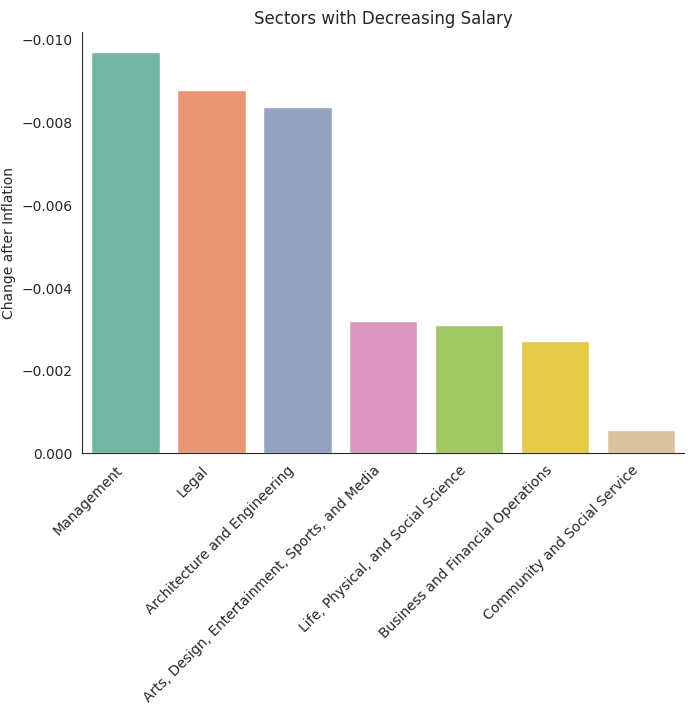

In [47]:
DecreasingSalary = SalaryIncrease_over_CPIIncrease[SalaryIncrease_over_CPIIncrease<0]
DecreasingSalary = DecreasingSalary.reset_index()
DecreasingSalary.columns = ['Category', 'Value']

with sns.axes_style('white'):
    g = sns.catplot(data = DecreasingSalary, x = "Category", y="Value", aspect = 1.5,
                       kind = "bar", palette='Set2')
    

plt.gca().invert_yaxis()
g.set_xticklabels(rotation=45, horizontalalignment='right')    
g.set_axis_labels("Category", "Change after Inflation")
plt.title('Sectors with Decreasing Salary', y=1, fontsize = 12)

plt.show()

Major sectors for which average salary increase is greatest over inflation


C:\Users\johnw\AppData\Local\Temp\ipykernel_19540\1111940774.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(data = IncreasingSalary, x = "Category", y="Value", aspect = 1,


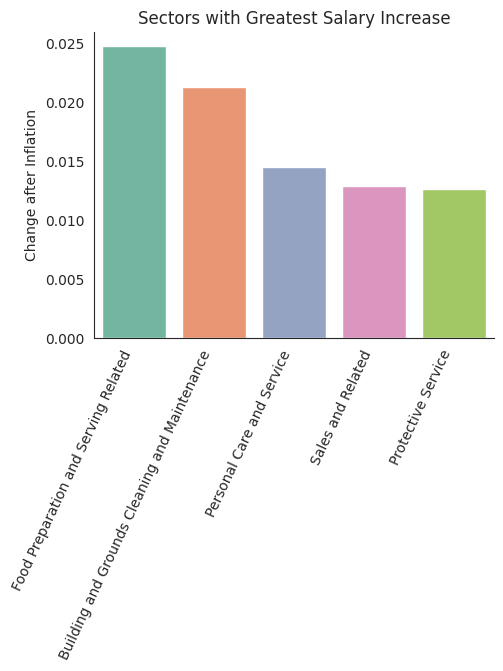

In [48]:
IncreasingSalary = SalaryIncrease_over_CPIIncrease.sort_values(ascending=False).head(5)

IncreasingSalary = IncreasingSalary.reset_index()
IncreasingSalary.columns = ['Category', 'Value']

with sns.axes_style('white'):
    g = sns.catplot(data = IncreasingSalary, x = "Category", y="Value", aspect = 1,
                       kind = "bar", palette = 'Set2')
    
plt.subplots_adjust(left=0.45, right=1.25, top=0.9, bottom=0.3)
g.set_xticklabels(rotation=65, horizontalalignment='right')    
g.set_axis_labels("", "Change after Inflation")
plt.title('Sectors with Greatest Salary Increase', y=1, fontsize = 12)
g.fig.set_size_inches(5, 5.1)

plt.show()

Sectors with Highest Employment Growth

In [49]:

MajorSectors['NewJobs'] = MajorSectors.groupby('OCC_TITLE')['TOT_EMP'].transform(lambda x: x - x.shift(1)).fillna(0)
#Number of new jobs over last 10 years
KCEmploymentGrowth = MajorSectors.groupby('OCC_TITLE')['NewJobs'].sum().sort_values(ascending=False)
KCEmploymentGrowth


OCC_TITLE
Transportation and Material Moving Occupations                37530.0
Healthcare Support Occupations                                19320.0
Business and Financial Operations Occupations                 15740.0
Management Occupations                                        13630.0
Healthcare Practitioners and Technical Occupations            11120.0
Production Occupations                                         7230.0
Computer and Mathematical Occupations                          5690.0
Construction and Extraction Occupations                        5650.0
Food Preparation and Serving Related Occupations               3800.0
Architecture and Engineering Occupations                       3430.0
Installation, Maintenance, and Repair Occupations              3220.0
Community and Social Service Occupations                       1410.0
Legal Occupations                                              1410.0
Education, Training, and Library Occupations                   1100.0
Protective

C:\Users\johnw\AppData\Local\Temp\ipykernel_19540\791377573.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(data = KCEmploymentGrowthTop, x = "Category", y="Value", aspect = 1,


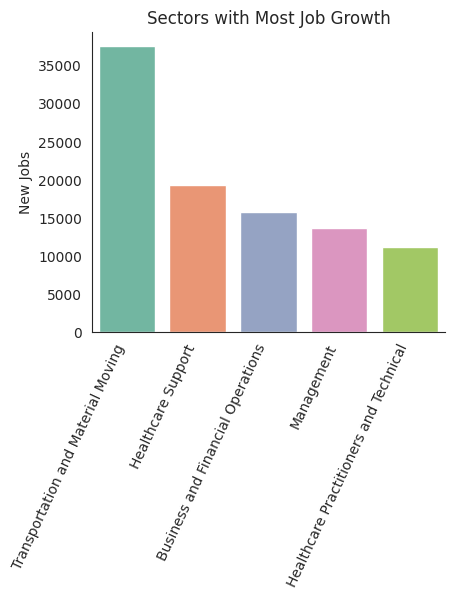

In [50]:
# KCEmploymentGrowth.head(5).plot(kind='bar')
KCEmploymentGrowth = MajorSectors.groupby('OCC_TITLE')['NewJobs'].sum().sort_values(ascending=False)
KCEmploymentGrowthTop = KCEmploymentGrowth.head(5)
KCEmploymentGrowthTop.index = KCEmploymentGrowthTop.index.str.replace(' Occupations', '')
KCEmploymentGrowthTop

KCEmploymentGrowthTop = KCEmploymentGrowthTop.reset_index()
KCEmploymentGrowthTop.columns = ['Category', 'Value']
KCEmploymentGrowthTop

with sns.axes_style('white'):
    g = sns.catplot(data = KCEmploymentGrowthTop, x = "Category", y="Value", aspect = 1,
                       kind = "bar", palette = 'Set2')
    
g.set_xticklabels(rotation=65, horizontalalignment='right')    
g.set_axis_labels("", "New Jobs")
plt.title('Sectors with Most Job Growth', y=1, fontsize = 12)
plt.subplots_adjust(left=0.55, right=1.25, top=0.9, bottom=0.3)
g.fig.set_size_inches(5.05, 5)


plt.show()

Emphasis on Transportation and Material Moving Occupations

In [51]:
Transportation = OWES[OWES['OCC_CODE'].str.startswith('53')]
Transportation = Transportation[Transportation['OCC_TITLE'] != 'Transportation and Material Moving Occupations']
#Some data was not available for all years and cannot be included
Transportation = Transportation[Transportation['OCC_TITLE'].map(Transportation['OCC_TITLE'].value_counts()) == 10]
Transportation['NewJobs'] = Transportation.groupby('OCC_TITLE')['TOT_EMP'].transform(lambda x: x - x.shift(1)).fillna(0)
Transportation.groupby('OCC_TITLE')['NewJobs'].sum().sort_values(ascending=False)

OCC_TITLE
Heavy and Tractor-Trailer Truck Drivers                   5490.0
Industrial Truck and Tractor Operators                    4510.0
Laborers and Freight, Stock, and Material Movers, Hand    1120.0
Cleaners of Vehicles and Equipment                         560.0
Bus Drivers, Transit and Intercity                         410.0
Commercial Pilots                                          160.0
Motor Vehicle Operators, All Other                          80.0
Traffic Technicians                                         70.0
Airfield Operations Specialists                             60.0
Crane and Tower Operators                                   60.0
Transportation Inspectors                                  -60.0
Refuse and Recyclable Material Collectors                 -120.0
Conveyor Operators and Tenders                            -200.0
Driver/Sales Workers                                      -240.0
Automotive and Watercraft Service Attendants              -260.0
Packers and Pac

Job Titles with most new jobs overall

C:\Users\johnw\AppData\Local\Temp\ipykernel_19540\4122114711.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(data = JobGrowth, x = "Category", y="Value", aspect = 1,


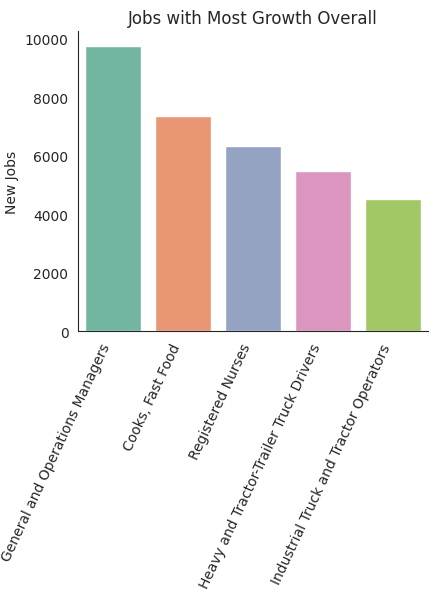

In [52]:
Detailed = OWES[OWES['O_GROUP']=='detailed']
Detailed.index = Detailed.index.astype('int64')
Detailed = Detailed[Detailed['OCC_TITLE'].map(Detailed['OCC_TITLE'].value_counts()) == 10]
Detailed['NewJobs'] = Detailed.groupby('OCC_TITLE')['TOT_EMP'].transform(lambda x: x - x.shift(1)).fillna(0)

#Number of new jobs over last 10 years
JobGrowth = Detailed.groupby('OCC_TITLE')['NewJobs'].sum().sort_values(ascending=False)
JobGrowth = JobGrowth.head(5)

JobGrowth = JobGrowth.reset_index()
JobGrowth.columns = ['Category', 'Value']

with sns.axes_style('white'):
    g = sns.catplot(data = JobGrowth, x = "Category", y="Value", aspect = 1,
                       kind = "bar", palette = 'Set2')
    
plt.subplots_adjust(left=0.55, right=1.25, top=0.9, bottom=0.3)
g.set_xticklabels(rotation=65, horizontalalignment='right')    
g.set_axis_labels("Category", "New Jobs")
plt.title('Jobs with Most Growth Overall', y=1, fontsize = 12)

plt.show()

Kansas City VS U.S. Employment Growth by Sector over Decade

C:\Users\johnw\AppData\Local\Temp\ipykernel_19540\712829958.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  OWESNmajor['NewJobs'] = OWESNmajor.groupby('OCC_TITLE')['TOT_EMP'].transform(lambda x: x - x.shift(1)).fillna(0)
C:\Users\johnw\AppData\Local\Temp\ipykernel_19540\712829958.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OWESNmajor['NewJobs'] = OWESNmajor.groupby('OCC_TITLE')['TOT_EMP'].transform(lambda x: x - x.shift(1)).fillna(0)


C:\Users\johnw\AppData\Local\Temp\ipykernel_19540\712829958.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KCStarting_Employment['OCC_TITLE'] = KCStarting_Employment['OCC_TITLE']
C:\Users\johnw\AppData\Local\Temp\ipykernel_19540\712829958.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KCStarting_Employment['EMP_GROWTH'] = KCStarting_Employment['OCC_TITLE'].map(KCEmploymentGrowth)
C:\Users\johnw\AppData\Local\Temp\ipykernel_19540\712829958.py:11: SettingWithCopyWarning: 
A value is trying to be set

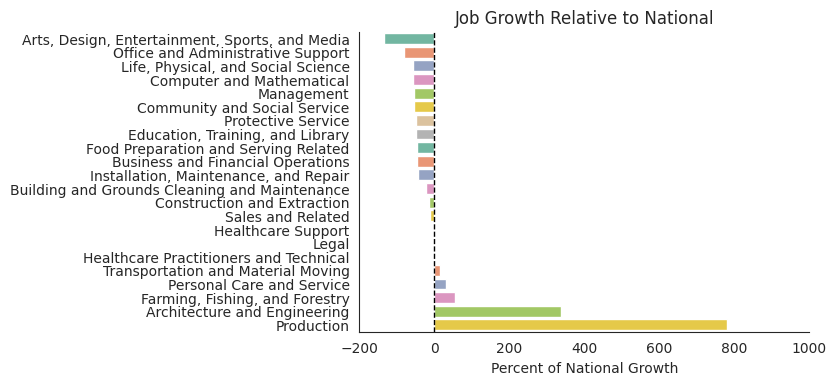

In [53]:
OWESNational = pd.concat(OWESN.values())

OWESNmajor = OWESNational[OWESNational['OCC_GROUP'] == 'major']
OWESNmajor['NewJobs'] = OWESNmajor.groupby('OCC_TITLE')['TOT_EMP'].transform(lambda x: x - x.shift(1)).fillna(0)
NEmploymentGrowth = OWESNmajor.groupby('OCC_TITLE')['NewJobs'].sum().sort_values(ascending=False)

KCStarting_Employment = MajorSectors[MajorSectors.index == 2014]
KCStarting_Employment['OCC_TITLE'] = KCStarting_Employment['OCC_TITLE']
KCStarting_Employment['EMP_GROWTH'] = KCStarting_Employment['OCC_TITLE'].map(KCEmploymentGrowth)

KCStarting_Employment['PCT_CHANGE'] = KCStarting_Employment['EMP_GROWTH'] / KCStarting_Employment['TOT_EMP']
KCEmpCHANGE = KCStarting_Employment[['OCC_TITLE', 'PCT_CHANGE']]
KCEmpCHANGE.set_index('OCC_TITLE', inplace=True)

NStarting_Employment = OWESNmajor[OWESNmajor['Year'] == '2014']
NStarting_Employment['EMP_GROWTH'] = NStarting_Employment.index.map(NEmploymentGrowth)
NStarting_Employment['PCT_CHANGE'] = NStarting_Employment['EMP_GROWTH'] / NStarting_Employment['TOT_EMP']
NEmpCHANGE = NStarting_Employment[['PCT_CHANGE']]

#KC Percent Diffrence of Increase over National Average
#Positive Result: KC outperformed the nation, Negative Result: KC underperformed the nation.
percentage_difference = ((KCEmpCHANGE - NEmpCHANGE) / abs(NEmpCHANGE)) * 100
percentage_difference = percentage_difference.sort_values(by='PCT_CHANGE')
percentage_difference.index = percentage_difference.index.str.replace(' Occupations', '')

percentage_difference = percentage_difference.reset_index()
percentage_difference.columns = ['Category', 'Value']

g.fig.set_size_inches(20, 8)
with sns.axes_style('white'):
    g = sns.catplot(data = percentage_difference, y = "Category", x="Value", aspect = 1.25,
                       kind = "bar", palette = 'Set2', height=6)
    
g.fig.set_size_inches(10, 5)
    
plt.subplots_adjust(left=0.35, right=.8, top=.9, bottom=0.3)
g.set_xticklabels(horizontalalignment='center')    
g.set_axis_labels("Percent of National Growth", '')
plt.title('Job Growth Relative to National', y=1, fontsize = 12)
g.ax.axvline(0, color='black', linewidth=1, linestyle='--')

plt.show()

Kansas City Average Unemployment Rate 2014-2023

C:\Users\johnw\AppData\Local\Temp\ipykernel_19540\1412254901.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  Avg_Unemp_Rate = pd.read_sql(queryEmpl, conn, index_col='Year')


<Axes: title={'center': 'Kansas City Unemployment Rate'}, xlabel='Year'>

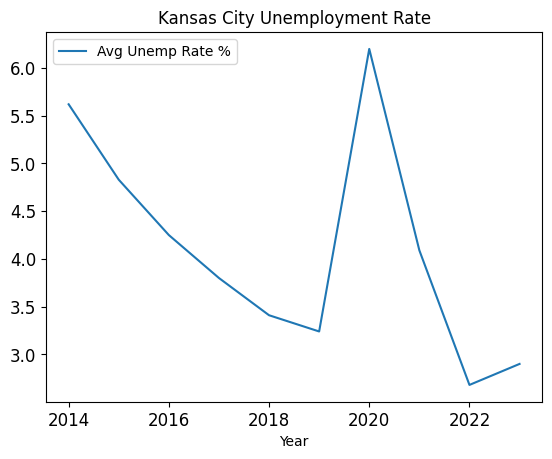

In [54]:
queryEmpl = 'SELECT `Year`, `Grand Total` FROM `unemployment rate` WHERE year BETWEEN 2014 AND 2023'
Avg_Unemp_Rate = pd.read_sql(queryEmpl, conn, index_col='Year')
Avg_Unemp_Rate.columns = ['Avg Unemp Rate %']
Avg_Unemp_Rate = Avg_Unemp_Rate.astype('float').round(2)
Avg_Unemp_Rate.plot(kind='line', title="Kansas City Unemployment Rate", fontsize=12)